In [1]:
import nltk
from nltk import RegexpTokenizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import time
import re
import numpy as np
import pandas as pd
import json
from pprint import pprint
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

#BeautifulSoup
from bs4 import BeautifulSoup
import requests

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.models.doc2vec import LabeledSentence

#PCA
from sklearn.decomposition import PCA

# spacy for lemmatization
import spacy

# Plotting tools FOR TOPIC MODELING
import pyLDAvis
import pyLDAvis.gensim  # don't skip this


# Enable logging for gensim - optional  (I HAVEN'T USED THIS YET)
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)


# NLTK Stop words -------------- ADD TO THESE AS WE SEE FIT
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS 

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

import pickle

pd.set_option('display.max_columns', 400)
pd.set_option('display.max_rows', 400)

# Import Novels

In [2]:
first_fifty = pickle.load( open( "pickled_novel_dict_0_50", "rb" ) )

In [3]:
second_fifty = pickle.load( open( "pickled_novel_dict_50_100", "rb" ) )
# favorite_color is now { "lion": "yellow", "kitty": "red" }d

In [4]:
titles = []

In [5]:
for i in first_fifty.keys():
    titles.append(i)

In [6]:
for i in second_fifty.keys():
    titles.append(i)

In [7]:
len(titles)

99

# Tokenize, Clean, and Tag Functions

In [8]:
def p_ize(novel):    
    broken = []
    start = 0
    end = 1200
    final = len(novel)
    while start < final:
        broken.append(novel[start:end])
        start += 1200
        end += 1200
    return broken

In [9]:
tokenizer = RegexpTokenizer(r'\w+')
stopword_set = set(stopwords.words('english'))

In [10]:
def model_tokenizer(input_data):
    lowered = input_data.lower()
    tokens = tokenizer.tokenize(lowered)
    return tokens

In [11]:
def lexicon(input_data):
    lowered = input_data.lower()
    tokens = tokenizer.tokenize(lowered)
    nonstop_tokens = list(set(tokens).difference(stopword_set))
    return nonstop_tokens

In [12]:
def token_keep_stop(input_data):
    lowered = input_data.lower()
    tokens = tokenizer.tokenize(lowered)
    return tokens

In [13]:
def token_no_stop(input_data):
    lowered = input_data.lower()
    tokens = tokenizer.tokenize(lowered)
    nonstop_tokens = [token for token in tokens if token not in stopword_set]
    return nonstop_tokens

# Word, Paragraph, and Lexicon Creation

In [14]:
book_word_length_0_50 = []
book_word_length_no_stop_0_50 = []
book_lexicon_length_0_50 = []

for i in list(first_fifty.values()):
    length = len(token_keep_stop(i))
    book_word_length_0_50.append(length)
    
    length_no_stop = len(token_no_stop(i))
    book_word_length_no_stop_0_50.append(length_no_stop)

    length_lexicon = len(lexicon(i))
    book_lexicon_length_0_50.append(length_lexicon)

In [15]:
len(book_word_length_0_50)

49

In [16]:
book_word_length_50_100 = []
book_word_length_no_stop_50_100 = []
book_lexicon_length_50_100 = []

for i in list(second_fifty.values()):
    length = len(token_keep_stop(i))
    book_word_length_50_100.append(length)
    
    length_no_stop = len(token_no_stop(i))
    book_word_length_no_stop_50_100.append(length_no_stop)

    length_lexicon = len(lexicon(i))
    book_lexicon_length_50_100.append(length_lexicon)

In [17]:
len(book_word_length_50_100)

50

In [18]:
book_word_length = book_word_length_0_50 + book_word_length_50_100

In [19]:
lexicon_length = book_lexicon_length_0_50 + book_lexicon_length_50_100

In [20]:
paragraph_count_0_50 = [len(p_ize(i))for i in first_fifty.values()]

In [21]:
paragraph_count_50_100 = [len(p_ize(i))for i in second_fifty.values()]

In [22]:
paragraph_count = paragraph_count_0_50 + paragraph_count_50_100

# DataFrames of Novels and Paragraphs

## Novels as a Whole

In [23]:
novels = pd.DataFrame()

In [24]:
novels['title'] = titles

In [25]:
novels['word_count'] = book_word_length

In [26]:
novels['lexicon_count'] = lexicon_length

In [27]:
novels['lex_total_ratio'] = novels.lexicon_count/novels.word_count

In [28]:
novels['paragraph_count'] = paragraph_count

### Literary-ness

**Following parameters can be played with (word count and lex_total_ratio) to find the sweet spot of 'wordy' or 'literary' novels/paragraphs.**

In [29]:
novels['over_150k_words_5perc_lex'] = np.where((novels.word_count > 150000) & (novels.lex_total_ratio >.05), 1, 0)

In [30]:
novels.head()

,title,word_count,lexicon_count,lex_total_ratio,paragraph_count,over_150k_words_5perc_lex
0,Pride and Prejudice,122876,6187,0.050352,568,0
1,FrankensteinOrThe Modern Prometheus,78092,7068,0.090509,363,0
2,A Journal of the Plague Year,94304,5573,0.059096,423,0
3,The Importance of Being EarnestA Trivial Comed...,21045,2481,0.117890,97,0
4,The Works of Edgar Allan PoeThe Raven Edition,423370,21029,0.049671,1981,0


In [31]:
most_literary = list(novels[novels.over_150k_words_5perc_lex == 1].title.values)

In [32]:
most_literary

['Moby DickOrThe Whale',
 'Little Women',
 'Dracula',
 'Jane EyreAn Autobiography',
 'Great Expectations',
 'Ulysses',
 'Oliver Twist',
 "Uncle Tom's Cabin",
 'The Jungle',
 'The Slang DictionaryEtymologicalHistorical and Andecdotal']

## Paragraphs

In [33]:
text = list(zip(titles,(list(first_fifty.values()) + list(second_fifty.values()))))

In [34]:
final = []
for i in text:
    name = i[0]
    paragraphs = p_ize(i[1])
    for i in paragraphs:
        final.append((name,i))

In [35]:
paragraphs = pd.DataFrame()

In [36]:
titles_p = [i[0] for i in final]

In [37]:
para_p = [i[1] for i in final]

In [38]:
paragraphs['title'] = titles_p

In [39]:
paragraphs['chunks'] = para_p

In [40]:
paragraphs['tokens'] = paragraphs['chunks'].map(lexicon)

In [41]:
paragraphs['tokens_in_order'] = paragraphs['chunks'].map(model_tokenizer)

In [42]:
paragraphs['tag'] = [str(i) for i in paragraphs.index]

In [43]:
paragraphs['token_count'] = [len(i) for i in paragraphs.tokens]

### Literary-ness

**Parameter for determining the most wordy or literary paragraphs.**

In [44]:
paragraphs['high_lexicon'] = np.where(paragraphs.token_count > 125, 1, 0)

In [45]:
paragraphs.head()

,title,chunks,tokens,tokens_in_order,tag,token_count,high_lexicon
0,Pride and Prejudice,CONTENTS Chapter 1 Chapter 2 Chapter 3 Chapte...,"[said, must, heard, possession, 44, 36, replie...","[contents, chapter, 1, chapter, 2, chapter, 3,...",0,105,0
1,Pride and Prejudice,"s,” returned she; “for Mrs. Long has just been...","[must, possession, replied, affect, see, four,...","[s, returned, she, for, mrs, long, has, just, ...",1,77,0
2,Pride and Prejudice,m as soon as he comes.” “I see no occasion for...,"[neighbourhood, must, assure, account, throw, ...","[m, as, soon, as, he, comes, i, see, no, occas...",2,73,0
3,Pride and Prejudice,rd for my little Lizzy.” “I desire you will do...,"[heard, replied, always, use, see, four, humou...","[rd, for, my, little, lizzy, i, desire, you, w...",3,85,0
4,Pride and Prejudice,to make his wife understand his character. He...,"[said, hypocritical, uncertain, nervous, belie...","[to, make, his, wife, understand, his, charact...",4,83,0


In [46]:
list(set(paragraphs[paragraphs['high_lexicon'] == 1].title.values))

['Index of Project Gutenberg Works on Black History',
 'Geschlecht und CharakterEnglish',
 'BeowulfAn Anglo-Saxon Epic Poem',
 'Ulysses',
 'Wuthering Heights',
 "La Navigation Aérienne L'aviation Et La Direction Des Aérostats Dans Les Temps Anciens Et Modernes",
 'The Picture of Dorian Gray',
 'The Decameron of Giovanni Boccaccio',
 'Second Treatise of Government',
 'Little Women',
 'The MemoirsCorrespondenceAnd MiscellaniesFrom The Papers Of Thomas Jefferson',
 'Also sprach ZarathustraEnglish',
 'The Works of Edgar Allan PoeThe Raven Edition',
 'The Slang DictionaryEtymologicalHistorical and Andecdotal',
 'The Iliad']

# EDA

## Novel EDA

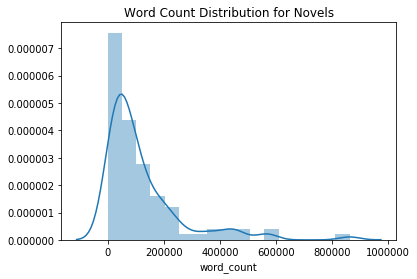

In [47]:
sns.distplot(novels.word_count)
plt.title('Word Count Distribution for Novels')
plt.show()

In [48]:
novels.word_count.describe()

count        99.000000
mean     121642.050505
std      144632.943993
min          94.000000
25%       37211.500000
50%       70054.000000
75%      155955.000000
max      862471.000000
Name: word_count, dtype: float64

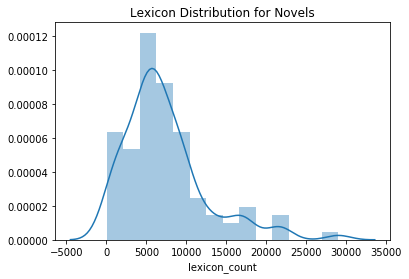

In [49]:
sns.distplot(novels.lexicon_count)
plt.title('Lexicon Distribution for Novels')
plt.show()

In [50]:
novels.lexicon_count.describe()

count       99.000000
mean      7267.262626
std       5267.477444
min         49.000000
25%       4248.500000
50%       6412.000000
75%       9094.500000
max      29012.000000
Name: lexicon_count, dtype: float64

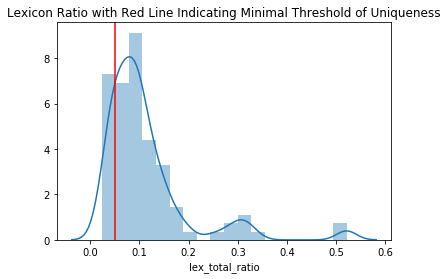

In [51]:
sns.distplot(novels.lex_total_ratio)
plt.axvline(.05, color='red')
plt.title('Lexicon Ratio with Red Line Indicating Minimal Threshold of Uniqueness')
plt.show()

In [52]:
novels.lex_total_ratio.describe()

count    99.000000
mean      0.111024
std       0.088999
min       0.022730
25%       0.056793
50%       0.088378
75%       0.121077
max       0.521277
Name: lex_total_ratio, dtype: float64

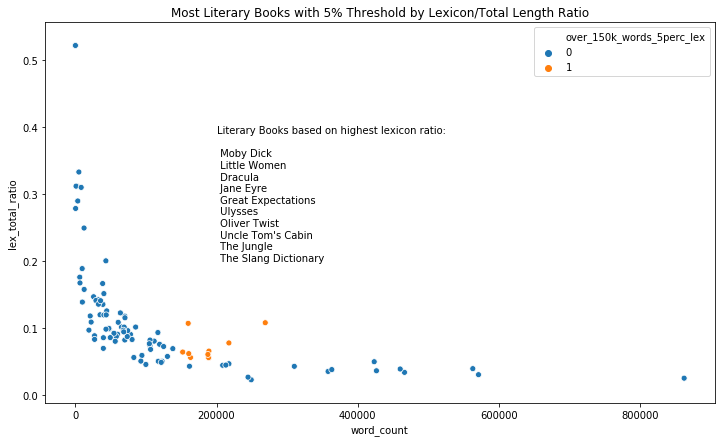

In [53]:
plt.figure(figsize=(12,7))
sns.scatterplot(novels.word_count, novels.lex_total_ratio, hue=novels.over_150k_words_5perc_lex)
plt.text(200000,.2, "Literary Books based on highest lexicon ratio: \n\n Moby Dick \n Little Women \n Dracula \n Jane Eyre \n Great Expectations \n Ulysses \n Oliver Twist \n Uncle Tom's Cabin \n The Jungle \n The Slang Dictionary")
plt.title('Most Literary Books with 5% Threshold by Lexicon/Total Length Ratio')
plt.show()

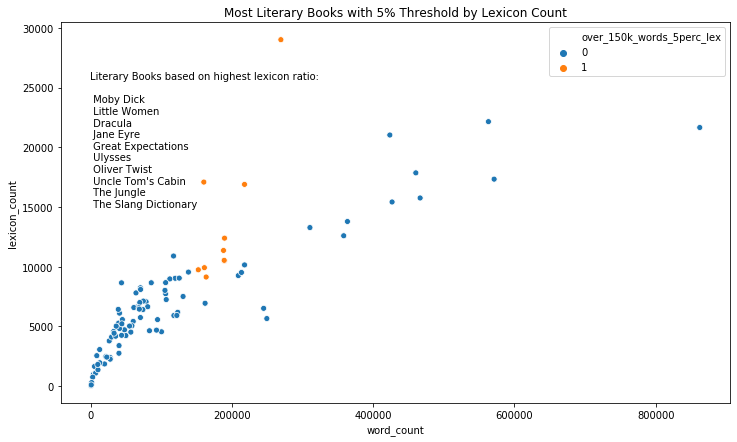

In [54]:
plt.figure(figsize=(12,7))
sns.scatterplot(novels.word_count, novels.lexicon_count, hue=novels.over_150k_words_5perc_lex)
plt.text(-1000,15000, "Literary Books based on highest lexicon ratio: \n\n Moby Dick \n Little Women \n Dracula \n Jane Eyre \n Great Expectations \n Ulysses \n Oliver Twist \n Uncle Tom's Cabin \n The Jungle \n The Slang Dictionary")
plt.title('Most Literary Books with 5% Threshold by Lexicon Count')
plt.show()

## Paragraph EDA

**Display of paragraphs above a certain literary threshold (125 unique words per paragraph) and their associated book titles below**

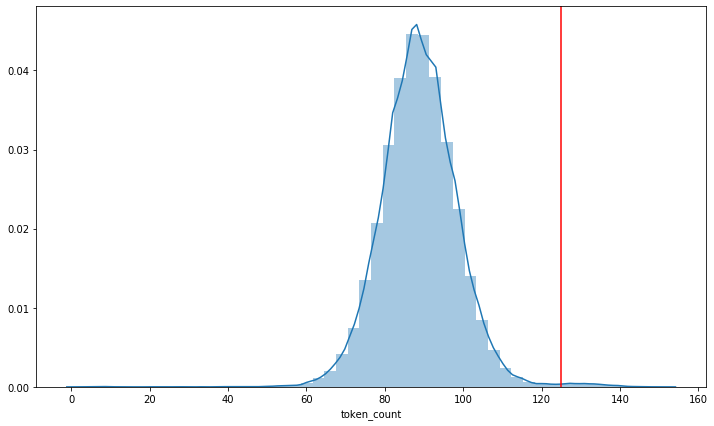

In [55]:
plt.figure(figsize=(12,7))
sns.distplot(paragraphs.token_count)
plt.axvline(125, color='red')
plt.show()

In [56]:
list(set(paragraphs[paragraphs['high_lexicon'] == 1].title.values))

['Index of Project Gutenberg Works on Black History',
 'Geschlecht und CharakterEnglish',
 'BeowulfAn Anglo-Saxon Epic Poem',
 'Ulysses',
 'Wuthering Heights',
 "La Navigation Aérienne L'aviation Et La Direction Des Aérostats Dans Les Temps Anciens Et Modernes",
 'The Picture of Dorian Gray',
 'The Decameron of Giovanni Boccaccio',
 'Second Treatise of Government',
 'Little Women',
 'The MemoirsCorrespondenceAnd MiscellaniesFrom The Papers Of Thomas Jefferson',
 'Also sprach ZarathustraEnglish',
 'The Works of Edgar Allan PoeThe Raven Edition',
 'The Slang DictionaryEtymologicalHistorical and Andecdotal',
 'The Iliad']

# Doc2Vec Model

In [57]:
def model_tokenizer(input_data):
    lowered = input_data.lower()
    tokens = tokenizer.tokenize(lowered)
    return tokens

In [58]:
all_tokens = [model_tokenizer(i) for i in paragraphs.chunks.values]

In [59]:
tagged = [TaggedDocument(words=chunk, tags=[str(i)]) for i, chunk in enumerate(all_tokens)]

In [78]:
third_model = pickle.load(open("third_model", "rb")) # not yet on github, so the following cells must be run 
                                                     # to obtain the model for the first time

In [61]:
# # MODEL PARAMETERS
# dm = 0 # 1 for distributed memory(default); 0 for dbow 
# size = 300
# context_window = 20
# seed = 0
# min_count = 10
# alpha = 0.01
# max_iter = 200

In [62]:
# # BUILD MODEL
# third_model = gensim.models.doc2vec.Doc2Vec(documents = tagged,
# dm = dm,
# alpha = alpha, # initial learning rate
# seed = seed,
# min_count = min_count, # ignore words with freq less than min_count
# max_vocab_size = None, # 
# window = context_window, # the number of words before and after to be used as context
# vector_size = size, # is the dimensionality of the feature vector
# sample = 1e-4, # ?
# negative = 5, # ? # number of cores
# epochs = max_iter) 

In [63]:
# pickle.dump(third_model, open("third_model", "wb" ))

In [64]:
def print_para_from_id(tag, rank, cosine):   
    start = tag - 1
    end = tag + 2
    name = paragraphs.loc[tag].title
    book_range = paragraphs[paragraphs.title == f'{name}'].index
    location = tag - book_range[0]
    length = book_range[-1] - book_range[0]
    percent = round((location/length)*100,2)
    print('NOVEL: ' + name, '\n')
    print('LOCATION IN NOVEL: AT PARAGRAPH {0} out of {1}, {2}% into the book'.format(location, length, percent), '\n')
    for i in range(start, end):
        if i < tag:
            try: 
                print('...' + paragraphs.chunks[i][-200:])
            except:
                print('Beginning of Novel')
        if i > tag:
            try:
                print(paragraphs.chunks[i][:200] + '...')
            except:
                print('End of Novel')
        if i == tag:
            print('**************************************************')
            print('                          {0} MOST SIMILAR PARAGRAPH, COSINE_SIMILARITY: {1}               '.format(rank, cosine),'\n')
            print(paragraphs.chunks[i])
            print('**************************************************')

In [65]:
def semantic_search(type_text_here, include_quoted_novel = True):
    # Tokenizes the input text, vectorizes it, and finds the 300 most similar tagged paragraphs.
    tokens = model_tokenizer(type_text_here)
    vector = third_model.infer_vector(tokens)
    top300 = third_model.docvecs.most_similar([vector], topn=300)
    final_tags = []
    final_tags_other_novels = []
    quoted_novel = paragraphs.loc[int(top300[0][0])].title
    
    # These need to be removed later from the whole DataFrame, but in the meantime this solution works
    rid = "La Navigation Aérienne L'aviation Et La Direction Des Aérostats Dans Les Temps Anciens Et Modernes"
    rid2 = "The Decameron of Giovanni Boccaccio"
    
    # The following two for-loops create final_tags and final_tags_other novels, which are used to
    # filter out results based on whether the user wants to include the quoted novel. 
    #
    # The numbers (> 20 here) filters out search results with 20 or fewer words, since the model 
    # is biased to think that short input strings are similar to short paragraphs, which only exist
    # at the beginning and end of novels, based on how they were broken up originally. 
    #
    # The rid statements are a short term solution for removing two Italian and French novels,
    # and the 'letter' and 'chapter' statements are used to remove most books' appendices. 
    
    for i in top300:
        if ((len(model_tokenizer(paragraphs.chunks[int(i[0])])) > 20) &
            (paragraphs.loc[int(i[0])].title != rid) &
            (paragraphs.loc[int(i[0])].title != rid2) &
            (model_tokenizer(paragraphs.chunks[int(i[0])]).count('letter') <10) &
            (model_tokenizer(paragraphs.chunks[int(i[0])]).count('chapter') <10)):
            final_tags.append(i)
            
    for i in top300:
        if ((len(model_tokenizer(paragraphs.chunks[int(i[0])])) > 20) &
            (paragraphs.loc[int(i[0])].title != rid) &
            (paragraphs.loc[int(i[0])].title != rid2) &
            (paragraphs.loc[int(i[0])].title != quoted_novel) &
            (model_tokenizer(paragraphs.chunks[int(i[0])]).count('letter') <10) &
            (model_tokenizer(paragraphs.chunks[int(i[0])]).count('chapter') < 10)):
                final_tags_other_novels.append(i)
                
                
    rank = ['FIRST', 'SECOND', 'THIRD', 'FOURTH', 'FIFTH']
    index = 0
    # The following two for-loops simply run the semantic search with or without the possibly-quoted novel, 
    # since otherwise the results will be dominated by paragraphs within the same novel. 
   
    if include_quoted_novel == True:
        print('                                  SEARCH RESULTS (INCLUDING THE QUOTED NOVEL)                             ', '\n')
        for i in final_tags[:5]:
            print('______________________________________________________________________________________')
            print(index + 1)
            rank_i = rank[index]
            cosine_i = round(i[1],4)
            tag_i = int(i[0])
            print_para_from_id(tag_i, rank_i, cosine_i)
            index += 1
            print('\n')
            print('______________________________________________________________________________________')
            
    if include_quoted_novel == False:
        print('                                  SEARCH RESULTS (*NOT* INCLUDING THE QUOTED NOVEL)                             ', '\n')
        for i in final_tags_other_novels[:5]:
            print('______________________________________________________________________________________')
            print(index + 1)
            rank_i = rank[index]
            cosine_i = round(i[1],4)
            tag_i = int(i[0])
            print_para_from_id(tag_i, rank_i, cosine_i)
            index += 1
            print('\n')
            print('______________________________________________________________________________________')

**Type in the following cell to set 'test' equal to the desired search string, and then run it 
through the semantic search function**

In [66]:
test = ''

In [67]:
test

''

In [ ]:
semantic_search(test, include_quoted_novel = True)

## Examples Demonstrating Usefulness

**Alice in Wonderland**

In [69]:
test = "It would have made a dreadfully ugly child but it makes rather a handsome pig."

In [70]:
test

'It would have made a dreadfully ugly child but it makes rather a handsome pig.'

In [71]:
semantic_search(test, include_quoted_novel = True)

                                  SEARCH RESULTS (INCLUDING THE QUOTED NOVEL)                              

______________________________________________________________________________________
1
NOVEL: Alice's Adventures in Wonderland 

LOCATION IN NOVEL: AT PARAGRAPH 54 out of 42093, 0.13% into the book 

...es were getting extremely small for a baby: altogether Alice did not like the look of the thing at all. “But perhaps it was only sobbing,” she thought, and looked into its eyes again, to see if there 
**************************************************
                          FIRST MOST SIMILAR PARAGRAPH, COSINE_SIMILARITY: 0.4967                

were any tears. No, there were no tears. “If you’re going to turn into a pig, my dear,” said Alice, seriously, “I’ll have nothing more to do with you. Mind now!” The poor little thing sobbed again (or grunted, it was impossible to say which), and they went on for some while in silence. Alice was just beginning to think to herself, “N

# PCA and Wordcloud Visualizations

In [72]:
def display_pca_scatterplot(model, words=None, sample=0):
    word_vectors = np.array([model[w] for w in words])

    twodim = PCA().fit_transform(word_vectors)[:,:2]
    
    plt.figure(figsize=(20,11))
    plt.scatter(twodim[:,0], twodim[:,1], edgecolors='k', c='r')
    for word, (x,y) in zip(words, twodim):
        plt.text(x, y, word, rotation=-15)

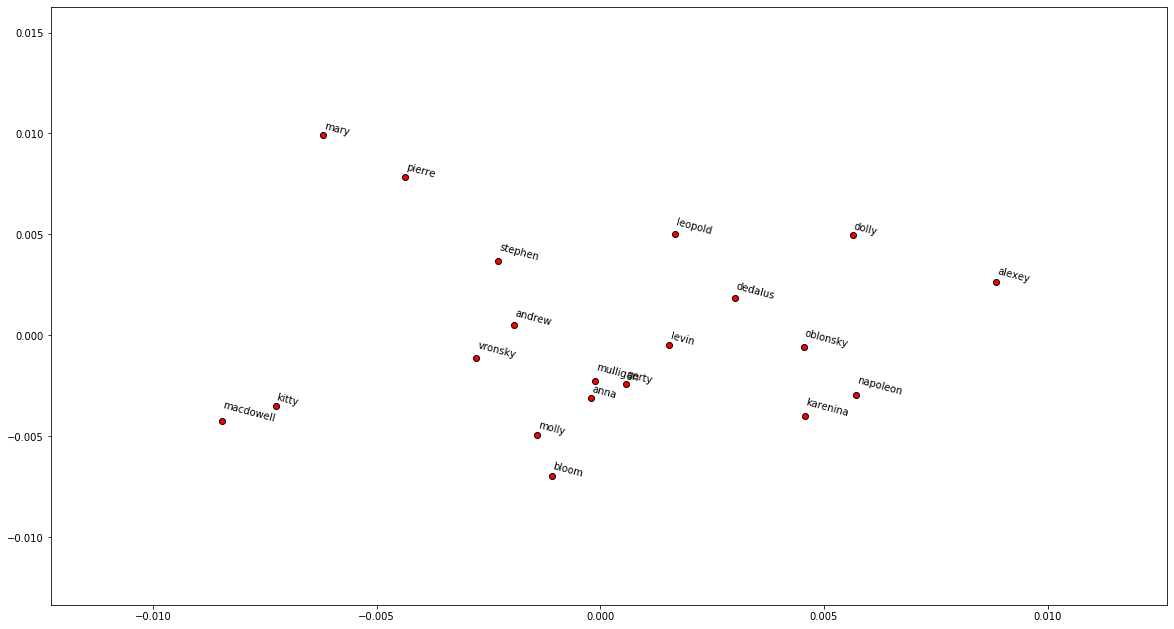

In [73]:
display_pca_scatterplot(third_model, 
                        ['andrew', 'napoleon','mary', 'pierre',
                         'kitty', 'vronsky', 'alexey','karenina', 'anna', 'levin', 'oblonsky', 'dolly',
                        'stephen','dedalus', 'bloom', 'mulligan', 'molly',
                        'leopold', 'gerty', 'macdowell'])

In [74]:
def give_index(book_title):
    return paragraphs[paragraphs.title == book_title].index

In [75]:
def make_wordcloud(book_name):
    from nltk.corpus import stopwords
    comment_words = []
    stopwords = stopwords.words('english')
    # iterate through the csv file 
    for val in paragraphs[paragraphs.title == f'{book_name}'].chunks: 

        # typecaste each val to string 
        val = str(val) 

        # split the value 
        tokens = val.split() 

        # Converts each token into lowercase 
        for i in range(len(tokens)): 
            tokens[i] = tokens[i].lower() 

        for words in tokens: 
            comment_words.append(words)
    
    final = ' '.join(comment_words)

    wordcloud = WordCloud(width = 800, height = 800, 
                    background_color ='white', 
                    stopwords = stopwords, 
                    min_font_size = 10,
                    colormap='magma').generate(final) 

    # plot the WordCloud image                        
    plt.figure(figsize = (8, 8), facecolor = None) 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 

    plt.show()

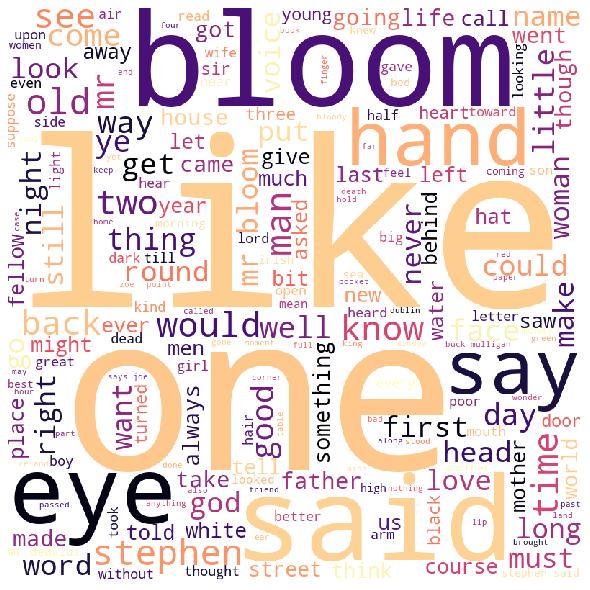

In [76]:
make_wordcloud("Ulysses")

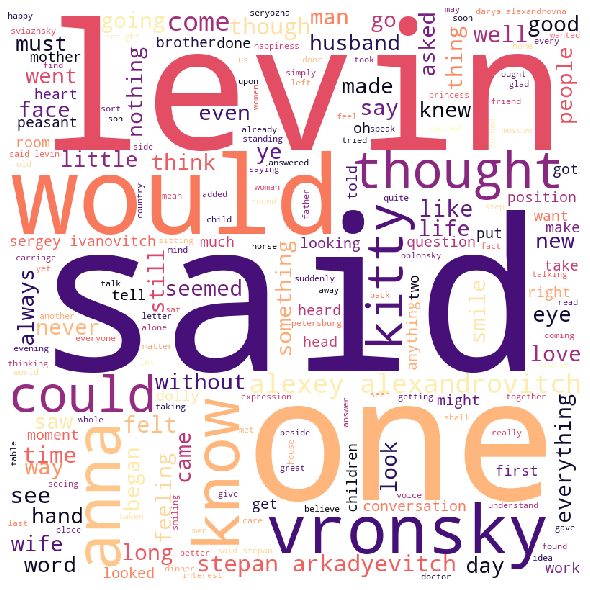

In [77]:
make_wordcloud("Anna Karenina")